# Cervical Screening Data Preprocessing
The dataset we are dealing with here is quite messy. The cervical images provided appear to come from a variety of sources, and have a lot of clutter in them. In some images you can see a speculum, some other colposcopy device, or many other areas of the vagina other than the cervix.

The dataset provided is also quite small, (a few hundred images of each cervix type). This means that we are unlikely to see these errors average out, and we are very likely to overfit the model.

The goal of this preprocessing is to create a system that can reliably isolate the cervical opening and surrounding area (the only part of the image that we should be training the model on). The strategy here is to:
- Tag several images with region of interest (ROI): a rectangle defining the 'area of interest' and excluding non-cervical parts of the image, as well as a point over the cervical opening.
- Train a CNN to tag ROIs based on these images.
- Review the results on test images, and select the best results to add to the training set.
- Retrain the CNN on the new, larger training set (bootstrapping), and check again that we are accurately identifying the cervical opening and area of interest.
- Use the trained CNN in pair with some basic CV tools to crop images and pass in relevant information to a new NN trained to identify cervical types.

Image tagging was done using the excellent VGG Image Annotator tool (http://www.robots.ox.ac.uk/~vgg/software/via/)

In [1]:
import pandas as pd
import numpy as np
import skimage as ski
from skimage import io, draw
import json

# There are truncated images in the dataset, and we need to be prepared to handle them
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Here we import images and relevant data that have been hand-tagged.

In [5]:
labels = pd.read_csv('annotations_bounding_boxes.csv')

# Everything below this line is just checking that imported data looks like something we're expecting.
#print(labels.head(5))
#for name in labels['region_shape_attributes']:
#    print(json.loads(name)['cx'])
#    print(name)
#
## A few quick tests to refresh on Pandas
#print(labels.loc[(labels['#filename']=='c2.jpg') & (labels['region_id']==0)]['region_attributes'])


Everything seems to be working as it should. Let's make a Pandas table and structure the data we want to use.

In [6]:
# Here we can see the structure we want to keep, the filename will be the unique identifier for each image
# Bounding radius defines an ellipse which should contain the cervix
# r/c - region / cervix, w/h - width / height p->proportional (0.00 - 1.00)
target_columns = ['filename', 'type', 'image', 'height', 'width', 'img_avg', 'ry', 'rx', 'rh', 'rw', 'cy', 'cx', \
                  'pry', 'prx', 'prh', 'prw', 'pcy', 'pcx']
targets = pd.DataFrame(columns=target_columns)

# We will add in all the tagging data into a dictionary (simple to do piecewise) and then import 
# the whole thing into a Pandas DataFrame in one step
target_dict = {}
    
for ifilename, text_attributes in zip(labels['#filename'], labels['region_shape_attributes']):
    iattr = json.loads(text_attributes)     # region_shape_attributes column (tagging data)
    if not iattr:
        # Blank cell, skip
        continue
    if ifilename not in target_dict:
        # New file, create new dictionary
        # Load file with PIL (so we can load truncated images)
        iImage = io.imread('./samples/'+ifilename, plugin='pil')
        target_dict[ifilename] = {'filename':ifilename, 'image':iImage, 'height':np.shape(iImage)[0],\
                                  'width':np.shape(iImage)[1], 'img_avg':np.mean(iImage, axis=(0,1))}
        
    ih = target_dict[ifilename]['height']
    iw = target_dict[ifilename]['width']
    
    if iattr['name'] == 'point':
        target_dict[ifilename].update({'cx':iattr['cx'], 'cy':iattr['cy']})
        target_dict[ifilename].update({'pcx':iattr['cx']/iw, 'pcy':iattr['cy']/ih})
        
    elif iattr['name'] == 'rect':
        target_dict[ifilename].update({'rx':iattr['x'], 'ry':iattr['y'], 'rh':iattr['height'], 'rw':iattr['width']})
        target_dict[ifilename].update({'prx':iattr['x']/iw, 'pry':iattr['y']/ih, 'prh':iattr['height']/ih, 'prw':iattr['width']/iw})
        

# Now we turn the dictionary of dicts into a dataframe:
targets = targets.append(list(target_dict.values()))

targets['type'] = targets['filename'].str.split('_').str.get(0).astype(np.int32)

# X,Y coordinates need to be integer types or we get errors later on:
cols = ['height', 'width', 'ry', 'rx', 'rh', 'rw', 'cy', 'cx']
targets[cols] = targets[cols].applymap(np.int32)
targets = targets.dropna()
print(targets.head(5))

KeyError: ''

This looks good, we have a pandas dataframe with image name, RGB data, cervical opening coordinates, cervical bounding ellipse coordinates and bounding ellipse shape.

Now let's try and overlay these shapes on the image and make sure everything makes sense.

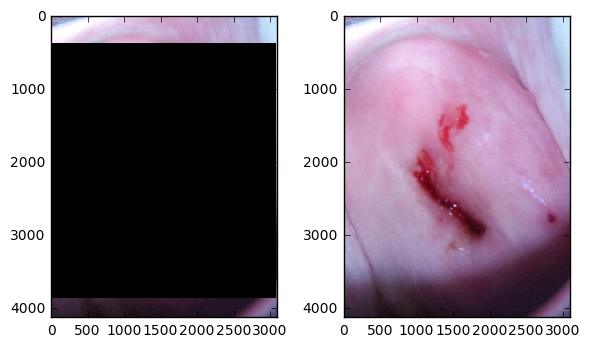

In [9]:
test_row = targets.loc[20]

# VERY IMPORTANT to use numpy to make a copy of the image at hand. Making a deep copy with Pandas fails
# since it is ultimately dependent on numpy making a deep copy of the image data
test_image = np.copy(test_row['image'])

x = test_row['rx']
y = test_row['ry']
w = test_row['rw']
h = test_row['rh']

# fill ROI polygon
test_poly = draw.polygon([y, y+h, y+h, y], [x, x, x+w, x+w],test_image.shape)

draw.set_color(test_image, test_poly, np.zeros(3))

io.imshow_collection([test_image, test_row['image']])
io.show()

Beautiful, we can see that the tagged data is overlaying the image as we would expect. Now we can tag more images (goal: 50 - 100) to use as training material for a neural network.

Let's save the table (without images) so we can do some machine learning on it.

Before we do that though, let's make sure to add the cervix TYPE to the dataframe

In [10]:
targets.drop('image', axis=1).to_csv('bounded_targets.csv')

In [11]:
print(np.mean(targets['img_avg']))

[ 127.62733364   92.46226351  105.61004269]
